# Validate ABoVE Shrubs Canopy Height Modeling
1. Make stacks with prediction layers (`do_stack()`)  
2. Send to JC for processing  
3. footprint the stacks; alternatively can footprint the predictions (`footprintlib`)
4. spatially select subset of preds or stacks to examine  
5. view a CHM prediction   
5. find intersection with LVIS footprints  
6. Get intersection polygons for validation (not needed to run validation function - just to pre-examine areas most useful for validation)    
7. validate for intersection of pred and lvis

Paul Montesano  
June 26 20223

In [421]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import above_shrubs.lib.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [423]:
from multiprocessing import Pool
from functools import partial

In [424]:
outstackdir = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/stacks'

#### Path to IFSAR DTM mosaic

In [425]:
dtm_path = '/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif'

In [426]:
TEST = False

#### Get SRLite strips

In [427]:
fn_list_srlite = glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/**/*.tif')
if TEST: fn_list_srlite = fn_list_srlite[0:2]
print(len(fn_list_srlite))

2075


In [428]:
fn_list_srlite_SUB = random.sample(fn_list_srlite, 20)
fn_list_srlite_SUB

['/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_7/WV02_20140503_M1BS_10300100316E0100-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_8/WV02_20170603_M1BS_103001006AAE4000-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_6/WV02_20170805_M1BS_103001006E3E8C00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_6/WV03_20190819_M1BS_10400100503D9200-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_4/WV02_20110711_M1BS_103001000CA4B000-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_5/WV02_20200805_M1BS_10300100ABC88800-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_5/WV03_20200604_M1BS_104001005CA50300-sr-02m.tif',
 '/explore/nobackup/project

### Make stacks

In [441]:
import importlib
importlib.reload(above_shrubs.lib.predlib)

<module 'above_shrubs.lib.predlib' from '/home/pmontesa/code/above-shrubs/above_shrubs/lib/predlib.py'>

In [445]:
# # Find and geth path for a small test case
# test_input_fn = [f for f in fn_list_srlite if 'WV03_20180921_M1BS_104001004242D900-sr-02m' in f]
# test_input_fn
# z = above_shrubs.lib.predlib.do_stack(test_input_fn[0], dtm_path='/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif', outdir='/home/pmontesa/code/above-shrubs')

In [ ]:
%%time
with Pool(processes=35) as pool:
    out_fn_list = pool.map(partial(above_shrubs.lib.predlib.do_stack, dtm_path='/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif', outdir=outstackdir), fn_list_srlite[0:1])

### Footprint stacks

In [85]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), out_fn_list)

CPU times: user 657 ms, sys: 738 ms, total: 1.39 s
Wall time: 12.8 s


In [117]:
footprint_gdf_stacks = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='CHM pred stack', DROP_DUPLICATES=True)

Building GDF from list...


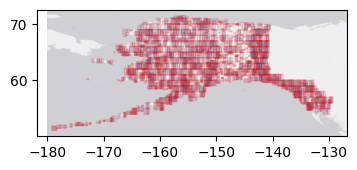

In [361]:
ax_main = footprint_gdf_stacks.plot(figsize=(4,4), alpha=0.15, ec='red')
ax_main = ctx.add_basemap(ax_main, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' ) #Esri.NatGeoWorldMap. Esri.WorldGrayCanvas Esri.WorldImagery